In [176]:
import findspark
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
findspark.init('C:\spark\spark\spark-2.2.0-bin-hadoop2.7')
session = pyspark.sql.SparkSession.builder.getOrCreate()

In [177]:
books=session.read.format("csv").option("header", "true").option("inferscheme", "true").option("sep", ";").load("BX-Books.csv")
users=session.read.format("csv").option("header", "true").option("inferscheme", "true").option("sep", ";").load("BX-Users.csv")
ratings=session.read.format("csv").option("header", "true").option("inferscheme", "true").option("sep", ";").load("BX-Book-Ratings.csv")

In [178]:
books.printSchema()
users.printSchema()
ratings.printSchema()
print(users)

root
 |-- ISBN: string (nullable = true)
 |-- Book-Title: string (nullable = true)
 |-- Book-Author: string (nullable = true)
 |-- Year-Of-Publication: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Image-URL-S: string (nullable = true)
 |-- Image-URL-M: string (nullable = true)
 |-- Image-URL-L: string (nullable = true)

root
 |-- User-ID: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: string (nullable = true)

root
 |-- User-ID: string (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- Book-Rating: string (nullable = true)

DataFrame[User-ID: string, Location: string, Age: string]


In [179]:
users = users.withColumn("Age", users.Age.cast("int"));
ratings = ratings.withColumn("Book-Rating", ratings["Book-Rating"].cast(DoubleType()))

In [180]:
users.printSchema()

root
 |-- User-ID: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: integer (nullable = true)



In [196]:
p_ratings=ratings.groupBy("Book-Rating").count().toPandas()
p_ratings

,Book-Rating,count
0,1,1770
1,6,36924
2,3,5996
3,5,50974
4,9,67541
5,4,8904
6,8,103736
7,7,76457
8,10,78610
9,2,2759


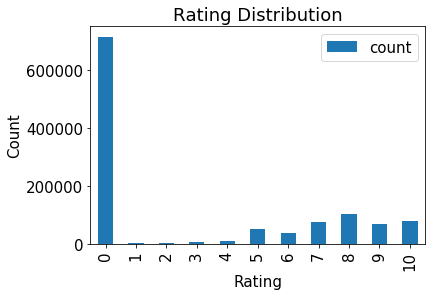

In [197]:
p_ratings = p_ratings.set_index(['Book-Rating']).sort_index()
plt.rc("font", size=15)
p_ratings.plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.savefig('system1.png', bbox_inches='tight')
plt.show()

In [183]:
p_ages=users.groupBy("Age").count().sort("Age").toPandas() 
p_ages.columns=['Age','Total_Numbers']
p_ages=p_ages.dropna()

Строим график распределения возрастов пользователей, возраст большинства пользователей находится примерно промежутке от 25ти до 75ти лет

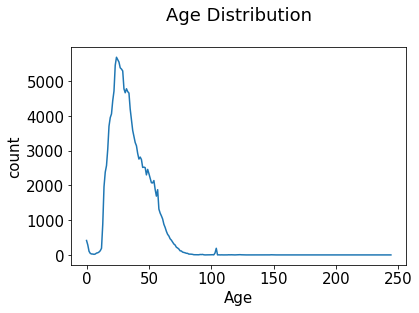

In [184]:
plt.plot(p_ages.Age,p_ages.Total_Numbers)
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('count')
plt.savefig('system2.png', bbox_inches='tight')
plt.show()

In [185]:
top_ratings=ratings.groupBy('ISBN').count().sort('count', ascending=False).head(5)
top_ratings=session.createDataFrame(top_ratings)
top_ratings.show()

+----------+-----+
|      ISBN|count|
+----------+-----+
|0971880107| 2502|
|0316666343| 1295|
|0385504209|  883|
|0060928336|  732|
|0312195516|  723|
+----------+-----+



In [186]:
books.join(top_ratings,books.ISBN == top_ratings.ISBN, 'inner').toPandas()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,ISBN,count
0,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,0385504209,883
1,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,0312195516,723
2,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,0316666343,1295
3,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,0060928336,732
4,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,0971880107,2502


In [211]:
from pyspark.sql import functions as F
top_ratings_by_avarage = ratings.groupBy("ISBN").agg(
    F.avg("Book-Rating").alias("bookRating"), 
).sort('bookRating', ascending=False).head(5)
top_ratings_by_avarage=session.createDataFrame(top_ratings_by_avarage)
top_ratings_by_avarage.show()

+----------+----------+
|      ISBN|bookRating|
+----------+----------+
|0373063121|      10.0|
|084233338X|      10.0|
|9504604730|      10.0|
|1413709672|      10.0|
|0671759574|      10.0|
+----------+----------+



In [213]:
books.join(top_ratings_by_avarage,books.ISBN == top_ratings_by_avarage.ISBN, 'inner').toPandas()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,ISBN,bookRating
0,0373063121,Found: One Husband (Harlequin Medical Romance),Meredith Webber,2001,Harlequin,http://images.amazon.com/images/P/0373063121.0...,http://images.amazon.com/images/P/0373063121.0...,http://images.amazon.com/images/P/0373063121.0...,0373063121,10.0
1,0671759574,ALISTAIR AND THE ALIEN INVASION,Marilyn Sadler,1994,Simon &amp; Schuster Children's Publishing,http://images.amazon.com/images/P/0671759574.0...,http://images.amazon.com/images/P/0671759574.0...,http://images.amazon.com/images/P/0671759574.0...,0671759574,10.0
2,1413709672,Looking at the Moon,Amanda Marie Clark,2003,PublishAmerica,http://images.amazon.com/images/P/1413709672.0...,http://images.amazon.com/images/P/1413709672.0...,http://images.amazon.com/images/P/1413709672.0...,1413709672,10.0
3,9504604730,Don Quijote de La Mancha,Miguel De Cervantes Saavedra,1998,Santillana S.A.,http://images.amazon.com/images/P/9504604730.0...,http://images.amazon.com/images/P/9504604730.0...,http://images.amazon.com/images/P/9504604730.0...,9504604730,10.0


In [224]:
user_rating_counts = ratings.groupBy("User-ID").count()
good_users = user_rating_counts.filter(user_rating_counts["count"]>=200)
filtered_ratings = good_users.join(ratings, on='User-ID', how='left_outer')

books_count = ratings.groupBy("ISBN").count()
books_select = books_count.filter(books_count['count'] >= 100)
filtered_ratings = books_select.join(filtered_ratings, on='ISBN', how='left_outer')
ratings_drop = filtered_ratings.drop('count')
ratings_drop.head(5)

[Row(ISBN='0515135739', User-ID='262399', Book-Rating=0),
 Row(ISBN='0515135739', User-ID='28591', Book-Rating=0),
 Row(ISBN='0515135739', User-ID='108285', Book-Rating=0),
 Row(ISBN='0515135739', User-ID='153662', Book-Rating=0),
 Row(ISBN='0515135739', User-ID='87746', Book-Rating=0)]

In [229]:
r_drop_count = ratings_drop.groupBy("ISBN").agg(
    F.avg("Book-Rating").alias("bookRating"), 
).sort('bookRating', ascending=False)

In [233]:
r_drop_count.show(5)

+----------+-----------------+
|      ISBN|       bookRating|
+----------+-----------------+
|0590353403|5.644444444444445|
|0439064864|5.596774193548387|
|0439136350|5.426470588235294|
|0439139597|5.343283582089552|
|039592720X|4.478260869565218|
+----------+-----------------+
only showing top 5 rows



In [237]:
ratings_pivot = ratings_drop.groupby('User-ID').pivot('ISBN').max('Book-Rating')

In [239]:
from pyspark.mllib.stat import Statistics
from pyspark.mllib.linalg import Vectors
rdd = ratings_pivot.rdd.map(lambda data: Vectors.dense([float(c) for c in data]))
particular_book_rdd = ratings_pivot.select('0316666343').rdd.map(lambda data: Vectors.dense([float(c) for c in data]))

In [243]:
ratings_pivot.limit(20).toPandas()

,User-ID,002542730X,0060008032,0060096195,006016848X,0060173289,0060175400,006019491X,0060199652,0060391626,...,1558744630,1558745157,1559029838,1573225517,1573225789,1573227331,1573229326,1573229571,1592400876,1878424319
0,230249,0.0,NaN,NaN,None,None,None,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
1,32773,NaN,NaN,NaN,None,None,None,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,None,NaN,NaN,NaN,NaN
2,227447,NaN,0.0,NaN,None,None,None,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,NaN,None,NaN,NaN,NaN,NaN
3,104665,NaN,NaN,NaN,None,None,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
4,148744,NaN,NaN,NaN,None,None,None,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,8.0,None,0.0,0.0,NaN,0.0
5,92547,NaN,NaN,NaN,None,None,None,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,None,NaN,NaN,NaN,NaN
6,241548,NaN,NaN,NaN,None,None,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7.0,None,NaN,NaN,NaN,NaN
7,131046,NaN,0.0,NaN,None,None,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,9.0,NaN
8,274061,NaN,NaN,NaN,None,None,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
9,126604,0.0,NaN,NaN,None,None,None,NaN,NaN,6.0,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN


In [244]:
from pyspark.ml.stat import Correlation


bones_book = '0316666343'
corr_values = {}
for book in ratings_pivot.columns[1:]:
    corr_values[book] = ratings_pivot.stat.corr(bones_book, book)

KeyboardInterrupt: 

In [ ]:
import operator
sorted_corr_values = sorted(corr_values.items(), key=operator.itemgetter(1))

In [ ]:
books_corr_to_bones = sc.parallelize([(k,)+(v,) for k,v in 
                                      dict(sorted_corr_values[-10:-1]).items()]).toDF(['ISBN','corr'])
books_corr_to_bones.limit(9).toPandas()

In [ ]:
books_corr_to_bones_info = books.join(books_corr_to_bones, on=['ISBN']).sort(desc("ISBN"))
books_corr_to_bones_info.limit(9).toPandas()